# Marketing Targets in Banking

This project aims to build, evaluate, and compare ensemble models with traditional machine learning techniques to predict customer subscription to bank term deposits. Using the Term Marketing - Banking dataset, which contains information on telephonic marketing campaigns conducted by a Portuguese bank, we focus on identifying customers most likely to subscribe. The primary objective is to improve the efficiency of customer targeting for term deposit marketing, which is resource-intensive due to high operational costs in large call centers.

#### This project includes multiple stages:

Data Preprocessing: Cleaning and transforming the dataset using techniques such as one-hot encoding and scaling to prepare it for analysis.

Baseline Models: Implementing logistic regression and k-Nearest Neighbors (k-NN) to establish baseline performance.

Ensemble Modelling: Developing and tuning models like Random Forest, AdaBoost, Bagging, and a Voting Classifier.
Performance Comparison: Evaluating model performance based on key metrics and runtime efficiency.

Business Implications: Justifying model selection based on precision-recall trade-offs, computational cost, and practical utility for the bank's marketing strategy.

## Part 1 - Data Processing

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file = '/Users/anmolmittal/Downloads/train 2.csv'
data = pd.read_csv(file, delimiter=';')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Convert the target variable 'y' to numeric for correlation analysis
data['y_numeric'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# EDA

We noticed there were no missing values in any of the columns, which is great for the analysis.

#### Looking at the numerical features:

Age: The ages of the clients range from 18 to 95, with an average of around 41. This shows that we have fairly diverse range of clients in terms of age.

Pdays: Most of the pdays values are -1, meaning many clients were not previously contacted. The minimum value of -1 confirms this, with a few clients having values up to 871.

Balance: The balance values vary widely, from -8,019 to 102,127. This suggests there might be some outliers or highly skewed data in this variable.

Duration: The duration, which represents the length of the last contact, ranges from 0 to 4,918 seconds. The wide range makes us think there could be some outliers here as well.

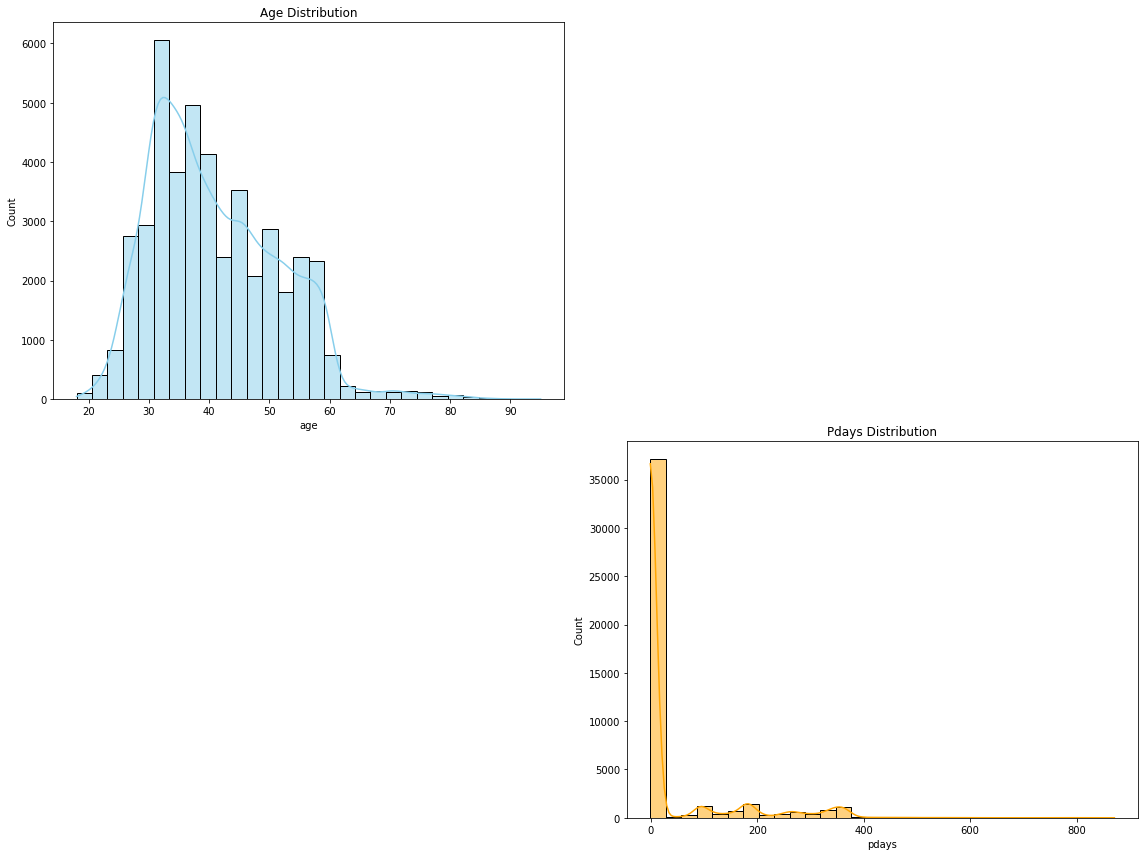

Text(0.5, 1.0, 'Duration Distribution')

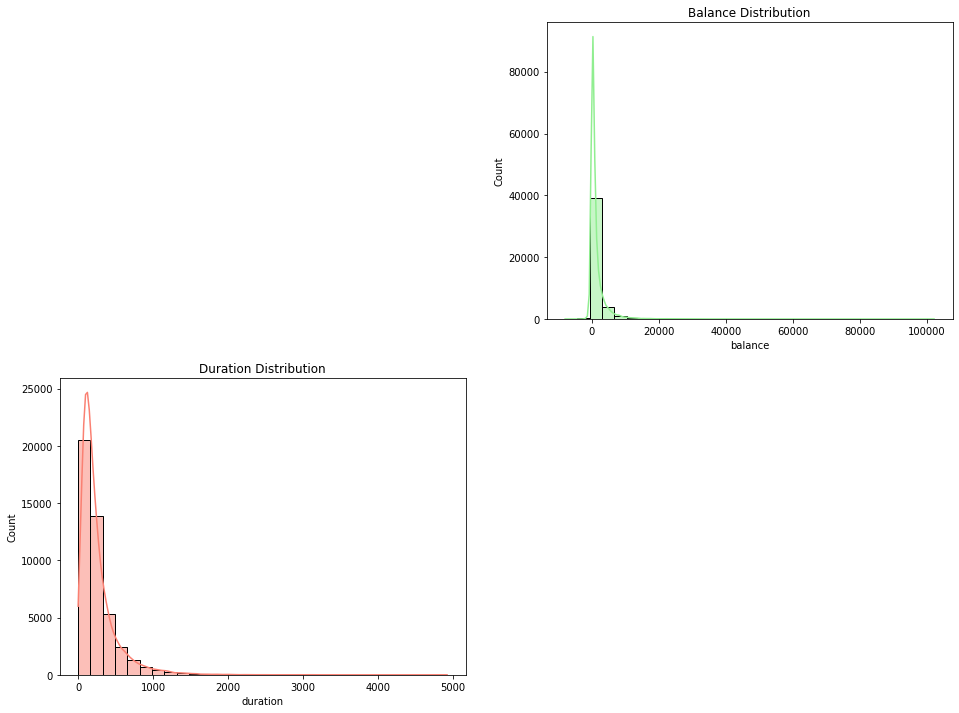

In [5]:
# 1. Distribution of numerical features
plt.figure(figsize=(16, 12))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(data['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')

# Pdays distribution
plt.subplot(2, 2, 4)
sns.histplot(data['pdays'], bins=30, kde=True, color='orange')
plt.title('Pdays Distribution')

plt.tight_layout()
plt.show()

# Balance distribution
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 2)
sns.histplot(data['balance'], bins=30, kde=True, color='lightgreen')
plt.title('Balance Distribution')

# Duration distribution
plt.subplot(2, 2, 3)
sns.histplot(data['duration'], bins=30, kde=True, color='salmon')
plt.title('Duration Distribution')

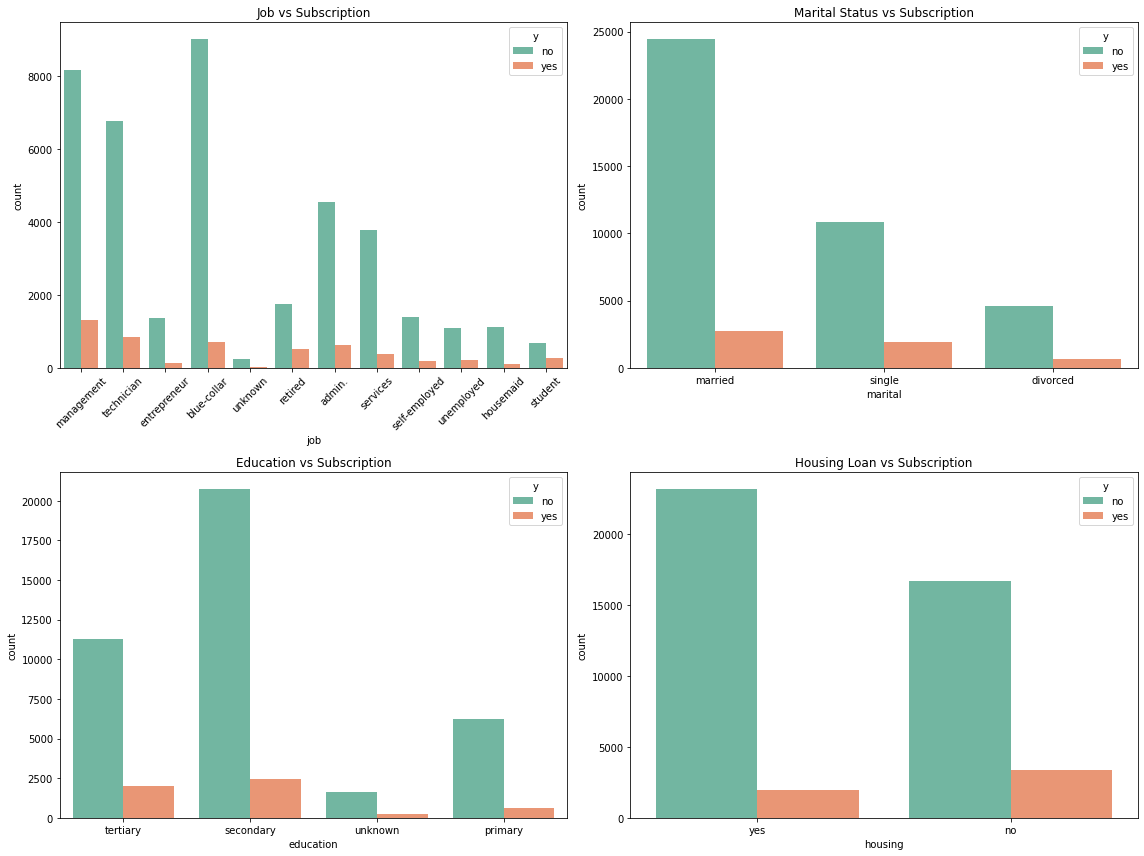

In [6]:
# 2. Categorical features vs Target variable (Subscription)
plt.figure(figsize=(16, 12))

# Job vs Subscription
plt.subplot(2, 2, 1)
sns.countplot(x='job', hue='y', data=data, palette='Set2')
plt.title('Job vs Subscription')
plt.xticks(rotation=45)

# Marital status vs Subscription
plt.subplot(2, 2, 2)
sns.countplot(x='marital', hue='y', data=data, palette='Set2')
plt.title('Marital Status vs Subscription')

# Education vs Subscription
plt.subplot(2, 2, 3)
sns.countplot(x='education', hue='y', data=data, palette='Set2')
plt.title('Education vs Subscription')

# Housing loan vs Subscription
plt.subplot(2, 2, 4)
sns.countplot(x='housing', hue='y', data=data, palette='Set2')
plt.title('Housing Loan vs Subscription')

plt.tight_layout()
plt.show()

#### Here's how we interpreted the categorical variables:

Job vs. Subscription:
We noticed that clients in certain jobs, like management, technician, and blue-collar, tend to have a higher count of non-subscribers. However, jobs such as retired and student show a greater proportion of clients who subscribed, which suggests that these groups might be more likely to accept the offer.

Marital Status vs. Subscription:
While married clients make up the largest group, we observed that they also have more non-subscribers compared to single or divorced clients. Interestingly, single clients seem to have a relatively higher proportion of subscriptions.

Education vs. Subscription:
We found that clients with tertiary education are more likely to subscribe than those with secondary or primary education. Meanwhile, those with unknown education levels have a lower subscription rate, which is consistent with what we expected.

Housing Loan vs. Subscription:
We see that clients without a housing loan are more likely to subscribe to the term deposit. This could indicate that having financial commitments like a housing loan may reduce the likelihood of subscribing.

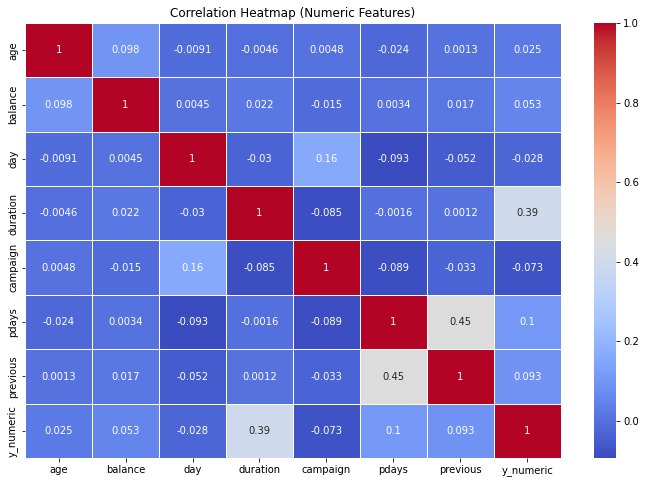

In [7]:
# 3. Correlation Heatmap
# Selecting only numeric columns for correlation
numeric_columns = data.select_dtypes(include=[np.number])

# Plotting the correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_columns.corr()

# Using a heatmap to visualize correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

## FEATURE ENGINEERING 

As Feature engineering is key to boosting model performance, especially with structured data. 

Beyond basic preprocessing like one-hot encoding and scaling, we have created binning numerical features like age or balance can group continuous values into categories for better pattern recognition. 
 
 We also handled outliers by clipping extreme values instead of applying log transformations. 
 
 Finally, creating interactions between categorical features (like job and education) and (balance and duration) helped tree-based models capture category-specific differences.

In [8]:
# Bin age into categorical groups
bins = [18, 30, 45, 60, 95]  # Define bin edges
labels = ['18-30', '31-45', '46-60', '60+']  # Define bin labels
data['age_binned'] = pd.cut(data['age'], bins=bins, labels=labels)

In [9]:
# Create interaction between categorical variables 'job' and 'education'
data['job_education'] = data['job'] + '_' + data['education']

In [10]:
# Create interaction between numerical variables 'balance' and 'duration'
data['balance_duration_interaction'] = data['balance'] * data['duration']

In [11]:
# Clip balance and duration values to reduce the impact of outliers
data['balance_clipped'] = data['balance'].clip(lower=data['balance'].quantile(0.01), upper=data['balance'].quantile(0.99))
data['duration_clipped'] = data['duration'].clip(lower=data['duration'].quantile(0.01), upper=data['duration'].quantile(0.99))

In [12]:
# Check the transformed data
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,y,y_numeric,age_binned,job_education,balance_duration_interaction,balance_clipped,duration_clipped
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,-1,0,unknown,no,0,46-60,management_tertiary,559323,2143.0,261
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,-1,0,unknown,no,0,31-45,technician_secondary,4379,29.0,151
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,-1,0,unknown,no,0,31-45,entrepreneur_secondary,152,2.0,76
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,-1,0,unknown,no,0,46-60,blue-collar_unknown,138552,1506.0,92
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,-1,0,unknown,no,0,31-45,unknown_unknown,198,1.0,198


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
# Prepare features and target
X = data.drop(columns='y')
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0) 

In [15]:

# Define categorical and numerical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'age_binned', 'job_education']
numerical_columns = ['balance_clipped', 'duration_clipped', 'campaign', 'pdays', 'previous', 'balance_duration_interaction']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Part 2: Build Baseline Models

## LOGISTIC REGRESSION MODEL

In [17]:
# Preprocessing pipeline for Logistic Regression
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

In [18]:
# Logistic Regression base model

logreg_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the base Logistic Regression model
logreg_pipeline_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance_clipped',
                                                   'duration_clipped',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'balance_duration_interaction']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_binned',
                                 

In [19]:
# Predictions and evaluation for base Logistic Regression model
y_pred_logreg_base = logreg_pipeline_base.predict(X_test)
base_logreg_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg_base),
    'Precision': precision_score(y_test, y_pred_logreg_base),
    'Recall': recall_score(y_test, y_pred_logreg_base),
    'F1 Score': f1_score(y_test, y_pred_logreg_base)
}

In [20]:
# Output the results for base Logistic Regression

print("Base Logistic Regression Metrics:", base_logreg_metrics)

Base Logistic Regression Metrics: {'Accuracy': 0.9016514302565615, 'Precision': 0.6444201312910285, 'Recall': 0.3685857321652065, 'F1 Score': 0.46894904458598724}


In [21]:
# Hyper Parameter Tuning for Logisitic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [22]:
# Define the parameter grid with class_weight
param_grid_logreg = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'classifier__penalty': ['l1', 'l2'],  
    'classifier__solver': ['liblinear'], 
    'classifier__class_weight': ['balanced']  
}

In [23]:
# Logistic Regression pipeline with class weighting
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression(max_iter=1000))
])

In [24]:
# GridSearchCV for Logistic Regression with class_weight='balanced'
grid_search_logreg_weighted = GridSearchCV(estimator=logreg_pipeline, param_grid=param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_logreg_weighted.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['balance_clipped',
                                                                          'duration_clipped',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'balance_duration_interaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                      

In [25]:
# Get the best Logistic Regression model with class weighting
best_logreg_weighted = grid_search_logreg_weighted.best_estimator_

In [26]:
# Predictions and evaluation for tuned Logistic Regression with class weighting
y_pred_logreg_weighted = best_logreg_weighted.predict(X_test)
tuned_logreg_weighted_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg_weighted),
    'Precision': precision_score(y_test, y_pred_logreg_weighted),
    'Recall': recall_score(y_test, y_pred_logreg_weighted),
    'F1 Score': f1_score(y_test, y_pred_logreg_weighted)
}

In [27]:
# Output the tuned results with class weighting
print("Tuned Logistic Regression with Class Weighting Metrics:", tuned_logreg_weighted_metrics)

Tuned Logistic Regression with Class Weighting Metrics: {'Accuracy': 0.8472427012680626, 'Precision': 0.42408712363869316, 'Recall': 0.8285356695869838, 'F1 Score': 0.5610169491525424}


### Inference: Logistic Regression

The Base Logistic Regression model achieves higher accuracy with low precision & recall. So, Logistic Regression typically uses a 0.5 threshold for binary classification. If the predicted probability for a class is above 0.5, the model assigns that class. On imbalanced datasets, many minority class (subscribers) may have predicted probabilities below this threshold, even if they are close, and will be classified as the majority class. Therefore, this leads to a large number of false negatives (subscribers that are misclassified as non-subscribers), which lowers recall and subsequently reduces the F1 score.

Hence, to mitigate the imbalanced dataset we use the balanced class weight method to hypertune our Logistic Regression model  which significantly improves recall(82.85%) and F1 score(56.10%). This leads to a significant increase in recall (from 37.11% to 82.85%) because the model becomes much more sensitive to the minority class and predicts more positive cases.
However, by predicting more positive cases, the model also introduces more false positives, which reduces precision. When the model predicts more subscribers (positive class), some of those predictions are incorrect, leading to a drop in precision. The precision-recall trade-off is inherent to classification tasks, especially in imbalanced datasets where changes aimed at increasing one metric (recall) often negatively impact the other.



## k-NN MODEL

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
# kNN Model

knn_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier()) 
])

# Fit the base k-NN model
knn_pipeline_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance_clipped',
                                                   'duration_clipped',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'balance_duration_interaction']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_binned',
                                 

In [30]:
# Predictions and evaluation for base k-NN

y_pred_knn_base = knn_pipeline_base.predict(X_test)
base_knn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_knn_base),
    'Precision': precision_score(y_test, y_pred_knn_base),
    'Recall': recall_score(y_test, y_pred_knn_base),
    'F1 Score': f1_score(y_test, y_pred_knn_base)
}

In [31]:
# Output the results for base k-NN
print("Base k-NN Metrics:", base_knn_metrics)

Base k-NN Metrics: {'Accuracy': 0.8928044824535535, 'Precision': 0.5820045558086561, 'Recall': 0.3197747183979975, 'F1 Score': 0.41276252019386106}


In [ ]:
# Hyper Parameter Tuning for kNN model

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [63]:
# Define the parameter grid for k-NN tuning
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],  
    'classifier__weights': ['uniform', 'distance'],  
    'classifier__p': [1, 2]  
}

In [64]:
# k-NN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [65]:
# GridSearchCV for k-NN 
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['balance_clipped',
                                                                          'duration_clipped',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'balance_duration_interaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome',
                                                                          'age_binned',
                                                                          'job_education'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [3, 5, 7, 9],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1')

In [67]:
# Get the best k-NN model from GridSearchCV
best_knn = grid_search_knn.best_estimator_

In [68]:
# Predictions and evaluation for tuned k-NN
y_pred_knn_tuned = best_knn.predict(X_test)
tuned_knn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_knn_tuned),
    'Precision': precision_score(y_test, y_pred_knn_tuned),
    'Recall': recall_score(y_test, y_pred_knn_tuned),
    'F1 Score': f1_score(y_test, y_pred_knn_tuned)
}

# Output the tuned k-NN results
print("Tuned k-NN Metrics:", tuned_knn_metrics)

Tuned k-NN Metrics: {'Accuracy': 0.8857269242111472, 'Precision': 0.5237623762376238, 'Recall': 0.3310387984981227, 'F1 Score': 0.40567484662576686}


### Inference: kNN 

In the code above, we used GridSearchCV to optimize the number of neighbors (n_neighbors) and the distance metric (p). However, the tuning did not lead to any significant improvement in the model's performance metrics.

One of the limitations of the k-NN model is its sensitivity to imbalanced data, which can lead to suboptimal performance, even after hyperparameter tuning.

Number of "No" responses (n): 39,922 instances

Number of "Yes" responses (y): 5,289 instances

This means that 5,289 customers subscribed to term deposits, while 39,922 did not.

Additionally, the accuracy decreased slightly after tuning, suggesting that the hyperparameter adjustments did not meaningfully improve overall performance, especially when focusing on precision and the F1 score—two key metrics in this context.

## Part 3: Ensemble Modelling


## 1) ADABOOST

In [77]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [78]:

# Define the parameter grid for AdaBoost
param_grid_adaboost = {
    'classifier__n_estimators': [50, 100, 200],  
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1]  
}

# AdaBoost pipeline
adaboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('classifier', AdaBoostClassifier(random_state=42))
])

In [79]:
# GridSearchCV for AdaBoost
grid_search_adaboost = GridSearchCV(estimator=adaboost_pipeline, param_grid=param_grid_adaboost, cv=5, scoring='f1', n_jobs=-1)
grid_search_adaboost.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['balance_clipped',
                                                                          'duration_clipped',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'balance_duration_interaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome',
                                                                          'age_binned',
                                                                          'job_education'])])),
                                       ('classifier',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.5, 1],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='f1')

In [80]:
# Get the best AdaBoost model
best_adaboost = grid_search_adaboost.best_estimator_

# Predictions and evaluation for AdaBoost
y_pred_adaboost = best_adaboost.predict(X_test)
adaboost_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_adaboost),
    'Precision': precision_score(y_test, y_pred_adaboost),
    'Recall': recall_score(y_test, y_pred_adaboost),
    'F1 Score': f1_score(y_test, y_pred_adaboost)
}

In [82]:
print("AdaBoost Metrics:", adaboost_metrics)


AdaBoost Metrics: {'Accuracy': 0.8989236213506341, 'Precision': 0.6164102564102564, 'Recall': 0.3760951188986233, 'F1 Score': 0.4671589584143024}


### Adaboost Model with SMOTE

In [110]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define SMOTE
smote = SMOTE(random_state=42)


In [111]:
# AdaBoost pipeline with SMOTE
adaboost_pipeline_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('smote', smote),  
    ('classifier', AdaBoostClassifier(random_state=42))  
])

In [112]:

# Define the parameter grid for AdaBoost
param_dist_adaboost = {
    'classifier__n_estimators': np.arange(50, 201, 50),
    'classifier__learning_rate': np.linspace(0.01, 1.0, 10)
}

In [113]:
# RandomizedSearchCV for AdaBoost with SMOTE
random_search_adaboost_smote = RandomizedSearchCV(estimator=adaboost_pipeline_smote, param_distributions=param_dist_adaboost, 
                                                  cv=5, scoring='f1', n_jobs=-1, random_state=42, n_iter=20)
random_search_adaboost_smote.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['balance_clipped',
                                                                                'duration_clipped',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'balance_duration_interaction']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_binned',
                                                                                'job_education'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              AdaBoostClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                        'classifier__n_estimators': array([ 50, 100, 150, 200])},
                   random_state=42, scoring='f1')

In [114]:
# Get the best AdaBoost model with SMOTE
best_adaboost_smote = random_search_adaboost_smote.best_estimator_

In [115]:
# Predictions and evaluation for AdaBoost with SMOTE
y_pred_adaboost_smote = best_adaboost_smote.predict(X_test)
adaboost_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_adaboost_smote),
    'Precision': precision_score(y_test, y_pred_adaboost_smote),
    'Recall': recall_score(y_test, y_pred_adaboost_smote),
    'F1 Score': f1_score(y_test, y_pred_adaboost_smote)
}

print("Tuned AdaBoost with SMOTE Metrics:", adaboost_smote_metrics)

Tuned AdaBoost with SMOTE Metrics: {'Accuracy': 0.8829991153052197, 'Precision': 0.5026842362127867, 'Recall': 0.6445556946182729, 'F1 Score': 0.5648478201261311}


### Inference: AdaBoost 

AdaBoost, which sequentially improves weak learners, achieved an accuracy of 88.30%, demonstrating its ability to make strong predictions on the dataset. Its precision (50.27%) indicates that roughly half of the predicted positives (likely subscribers) are correct, which is decent given the complexity of the data. 

The recall (64.46%) shows that it successfully captures the majority of actual subscribers, making it effective for customer targeting in marketing campaigns. 

The F1 score (56.48%), a balance between precision and recall, suggests that AdaBoost manages both metrics moderately well. What makes AdaBoost stand out is its computational efficiency, as it trains faster than Random Forest and Bagging while offering solid performance. 

For business applications requiring frequent model updates and real-time decision-making, AdaBoost’s combination of strong recall and manageable computational cost makes it the most practical solution for large-scale marketing campaigns, ensuring efficient customer targeting without overwhelming computational resources.

## 2) BAGGING CLASSIFIER

In [88]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [91]:
# Bagging pipeline with the updated parameter name
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))
])

In [92]:
# Define the parameter grid for Bagging
param_grid_bagging = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_samples': [0.5, 0.7, 1.0],
    'classifier__bootstrap': [True, False]
}

In [94]:
# GridSearchCV for Bagging
grid_search_bagging = GridSearchCV(estimator=bagging_pipeline, param_grid=param_grid_bagging, cv=3, scoring='f1', n_jobs=-1)
grid_search_bagging.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['balance_clipped',
                                                                          'duration_clipped',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'balance_duration_interaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome',
                                                                          'age_binned',
                                                                          'job_education'])])),
                                       ('classifier',
                                        BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_samples': [0.5, 0.7, 1.0],
                         'classifier__n_estimators': [10, 50, 100]},
             scoring='f1')

In [95]:
# Get the best Bagging model
best_bagging = grid_search_bagging.best_estimator_

In [132]:
# Predictions and evaluation for Bagging Classifier
y_pred_bagging = best_bagging.predict(X_test)
bagging_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_bagging),
    'Precision': precision_score(y_test, y_pred_bagging),
    'Recall': recall_score(y_test, y_pred_bagging),
    'F1 Score': f1_score(y_test, y_pred_bagging)
}

print("Base Bagging Metrics:", bagging_metrics)

Base Bagging Metrics: {'Accuracy': 0.9031996461220879, 'Precision': 0.6248904469763366, 'Recall': 0.44618272841051315, 'F1 Score': 0.520627966411099}


### BAGGING CLASSIFIER (WITH SMOTE)

In [116]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging pipeline with SMOTE
bagging_pipeline_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))
])

In [119]:
# Define the parameter grid for Bagging
param_dist_bagging = {
    'classifier__n_estimators': np.arange(10, 61, 10),
    'classifier__max_samples': np.linspace(0.5, 1.0, 3),
    'classifier__bootstrap': [True, False]
}

In [120]:
# RandomizedSearchCV for Bagging with SMOTE 
random_search_bagging_smote = RandomizedSearchCV(estimator=bagging_pipeline_smote, param_distributions=param_dist_bagging, 
                                                 cv=3, scoring='f1', n_jobs=-1, random_state=42, n_iter=10)
random_search_bagging_smote.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['balance_clipped',
                                                                                'duration_clipped',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'balance_duration_interaction']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_binned',
                                                                                'job_education'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                                random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_samples': array([0.5 , 0.75, 1.  ]),
                                        'classifier__n_estimators': array([10, 20, 30, 40, 50, 60])},
                   random_state=42, scoring='f1')

In [121]:
# Get the best Bagging model with SMOTE
best_bagging_smote = random_search_bagging_smote.best_estimator_

In [122]:
# Predictions and evaluation for Bagging Classifier with SMOTE
y_pred_bagging_smote = best_bagging_smote.predict(X_test)
bagging_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_bagging_smote),
    'Precision': precision_score(y_test, y_pred_bagging_smote),
    'Recall': recall_score(y_test, y_pred_bagging_smote),
    'F1 Score': f1_score(y_test, y_pred_bagging_smote)
}

print("Tuned Bagging with SMOTE Metrics:", bagging_smote_metrics)

Tuned Bagging with SMOTE Metrics: {'Accuracy': 0.8889708050722501, 'Precision': 0.5259887005649717, 'Recall': 0.5826032540675845, 'F1 Score': 0.5528503562945368}


### Inference: Bagging Classifier

Bagging delivered the highest accuracy (88.90%) among the models, showcasing its ability to generalize well across various data subsets. Its precision (52.60%) is slightly higher than AdaBoost, meaning it makes fewer false positive predictions, which is beneficial for reducing marketing costs. 

However, the recall (58.26%) is slightly lower, indicating that it may miss some potential subscribers compared to AdaBoost. 

The F1 score (55.28%) reflects a decent balance between precision and recall, but not as strong as AdaBoost's ability to capture more actual positives. 

While Bagging offers solid predictive power, its computational cost was higher than AdaBoost, taking longer to train. For a business scenario requiring frequent model retraining and real-time predictions, Bagging’s computational inefficiency compared to AdaBoost makes it less favorable, even though it offers higher precision. AdaBoost remains the better choice due to its efficiency in both training and performance.

## 3) VOTING CLASSIFIER

In [83]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [84]:
# Initialize base models
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()

In [85]:
# Define a Voting Classifier (soft voting for probabilistic predictions)
voting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=[
        ('logreg', logreg),
        ('knn', knn),
        ('adaboost', AdaBoostClassifier(random_state=42))
    ], voting='soft'))  
])

In [86]:
# GridSearchCV for Voting Classifier (no hyperparameter tuning here for simplicity)
voting_pipeline.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance_clipped',
                                                   'duration_clipped',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'balance_duration_interaction']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_binned',
                                                   'job_education'])])),
                ('classifier',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(max_iter=1000)),
                                              ('knn', KNeighborsClassifier()),
                                              ('adaboost',
                                               AdaBoostClassifier(random_state=42))],
                                  voting='soft'))])

In [133]:
# Predictions and evaluation for Voting Classifier
y_pred_voting = voting_pipeline.predict(X_test)
voting_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Precision': precision_score(y_test, y_pred_voting),
    'Recall': recall_score(y_test, y_pred_voting),
    'F1 Score': f1_score(y_test, y_pred_voting)
}

print("Base Voting Classifier Metrics:", voting_metrics)

Base Voting Classifier Metrics: {'Accuracy': 0.9009141846063108, 'Precision': 0.6453089244851259, 'Recall': 0.35294117647058826, 'F1 Score': 0.4563106796116505}


### VOTING CLASSIFIER (WITH SMOTE)

In [123]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Initialize base models
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()


In [124]:
# Voting pipeline with SMOTE
voting_pipeline_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', VotingClassifier(estimators=[
        ('logreg', logreg),
        ('knn', knn),
        ('adaboost', AdaBoostClassifier(random_state=42))
    ], voting='soft'))
])

In [125]:
# Fit Voting Classifier with SMOTE 
voting_pipeline_smote.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance_clipped',
                                                   'duration_clipped',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'balance_duration_interaction']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_binned',
                                                   'job_education'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(max_iter=1000)),
                                              ('knn', KNeighborsClassifier()),
                                              ('adaboost',
                                               AdaBoostClassifier(random_state=42))],
                                  voting='soft'))])

In [126]:
# Predictions and evaluation for Voting Classifier with SMOTE
y_pred_voting_smote = voting_pipeline_smote.predict(X_test)
voting_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_voting_smote),
    'Precision': precision_score(y_test, y_pred_voting_smote),
    'Recall': recall_score(y_test, y_pred_voting_smote),
    'F1 Score': f1_score(y_test, y_pred_voting_smote)
}

print("Voting Classifier with SMOTE Metrics:", voting_smote_metrics)

Voting Classifier with SMOTE Metrics: {'Accuracy': 0.8469478030079622, 'Precision': 0.4192021636240703, 'Recall': 0.7759699624530664, 'F1 Score': 0.5443371378402108}


### Inference: Voting Classifier

The Voting Classifier, combining predictions from multiple models, excelled in recall (77.60%), making it the most effective at capturing potential subscribers. 

However, its precision (41.92%) is the lowest among the models, meaning that it produces a higher number of false positives. This can be costly for marketing campaigns, as resources may be wasted on non-converting customers. 

The accuracy (84.69%) is also lower than other models, indicating that its overall prediction ability is less reliable. 

With an F1 score of 54.43%, Voting Classifier prioritizes recall over precision, favoring the identification of subscribers at the expense of precision. Additionally, its computational cost was higher than AdaBoost, making it less suitable for business processes where cost-efficiency is critical. Despite its strong recall, the Voting Classifier’s lower precision and higher computational demands make it a suboptimal choice compared to AdaBoost, which strikes a better balance for targeted marketing.

## RANDOM FOREST MODELLING

In [99]:
from sklearn.ensemble import RandomForestClassifier


In [100]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__max_depth': [None, 10, 20],  
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4]  
}

In [101]:
# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [103]:
# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['balance_clipped',
                                                                          'duration_clipped',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'balance_duration_interaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome',
                                                                          'age_binned',
                                                                          'job_education'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='f1')

In [104]:
# Get the best Random Forest model
best_rf = grid_search_rf.best_estimator_

In [105]:
# Predictions and evaluation for Random Forest
y_pred_rf = best_rf.predict(X_test)
rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf)
}

print(" Random Forest Metrics:", rf_metrics)

Tuned Random Forest Metrics: {'Accuracy': 0.9026098496018874, 'Precision': 0.651697699890471, 'Recall': 0.3723404255319149, 'F1 Score': 0.4739147749900438}


### RANDOM FOREST (SMOTE)

In [127]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Random Forest pipeline with SMOTE
rf_pipeline_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [128]:
# Define the parameter grid for Random Forest
param_dist_rf = {
    'classifier__n_estimators': np.arange(50, 151, 50),
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': np.arange(2, 6),
    'classifier__min_samples_leaf': np.arange(1, 3)
}

In [129]:
# RandomizedSearchCV for Random Forest with SMOTE
random_search_rf_smote = RandomizedSearchCV(estimator=rf_pipeline_smote, param_distributions=param_dist_rf, 
                                            cv=3, scoring='f1', n_jobs=-1, random_state=42, n_iter=10)
random_search_rf_smote.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['balance_clipped',
                                                                                'duration_clipped',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'balance_duration_interaction']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome',
                                                                                'age_bi...,
                                                                                'job_education'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20],
                                        'classifier__min_samples_leaf': array([1, 2]),
                                        'classifier__min_samples_split': array([2, 3, 4, 5]),
                                        'classifier__n_estimators': array([ 50, 100, 150])},
                   random_state=42, scoring='f1')

In [130]:
# Get the best Random Forest model with SMOTE
best_rf_smote = random_search_rf_smote.best_estimator_


In [131]:
# Predictions and evaluation for Random Forest with SMOTE
y_pred_rf_smote = best_rf_smote.predict(X_test)
rf_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf_smote),
    'Precision': precision_score(y_test, y_pred_rf_smote),
    'Recall': recall_score(y_test, y_pred_rf_smote),
    'F1 Score': f1_score(y_test, y_pred_rf_smote)
}

print("Tuned Random Forest with SMOTE Metrics:", rf_smote_metrics)


Tuned Random Forest with SMOTE Metrics: {'Accuracy': 0.887864936596874, 'Precision': 0.5197334700153767, 'Recall': 0.6345431789737171, 'F1 Score': 0.5714285714285714}


### Inference: Random Forest

Random Forest exhibited strong performance with accuracy (88.79%), a solid precision (51.97%), and a balanced recall (63.45%). These metrics indicate that Random Forest performs well in identifying subscribers while minimizing false positives. 

The F1 score (57.14%) shows that it effectively balances precision and recall, making it a reliable model for predicting term deposit subscriptions. However, the key drawback of Random Forest is its high computational cost, as it took the longest to train among all models. 

This extended training time makes it impractical for business environments where frequent model retraining and timely decision-making are critical. While Random Forest offers excellent predictive capabilities, its significant resource consumption limits its scalability and practicality. In contrast, AdaBoost provides comparable performance with far less computational overhead, making it the better model for real-time marketing applications where cost-effectiveness and quick decision-making are essential.

### PRECISION RECALL CURVE (AUC)

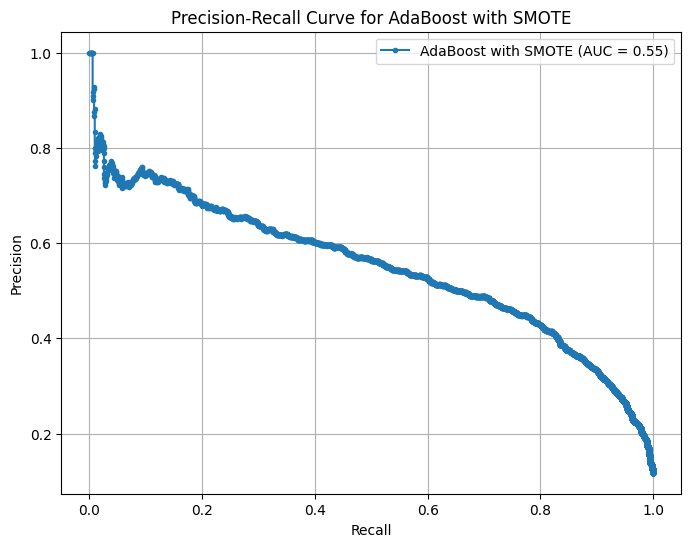

In [140]:
# Adaboost Model

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the probability predictions for the positive class (class 1)
y_proba_adaboost_smote = best_adaboost_smote.predict_proba(X_test)[:, 1]

# Calculate precision and recall at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_adaboost_smote)

# Calculate the average precision score (equivalent to AUC for precision-recall curve)
auc_pr = average_precision_score(y_test, y_proba_adaboost_smote)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AdaBoost with SMOTE (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AdaBoost with SMOTE')
plt.legend()
plt.grid()
plt.show()

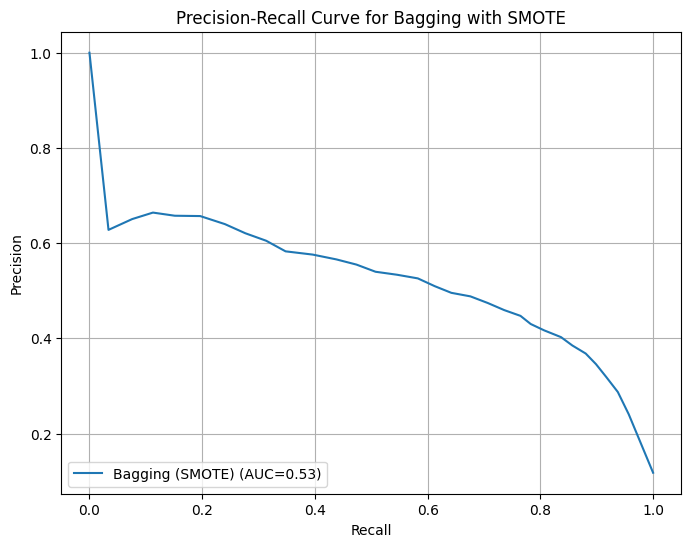

In [135]:
# Bagging Classifier

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (class 1)
y_scores_bagging_smote = best_bagging_smote.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_test, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={auc_score:.2f})')

# Plot Precision-Recall Curve for Bagging with SMOTE
plt.figure(figsize=(8, 6))

plot_precision_recall_curve(y_test, y_scores_bagging_smote, "Bagging (SMOTE)")

# Add plot labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Bagging with SMOTE')
plt.legend(loc='lower left')
plt.grid()
plt.show()


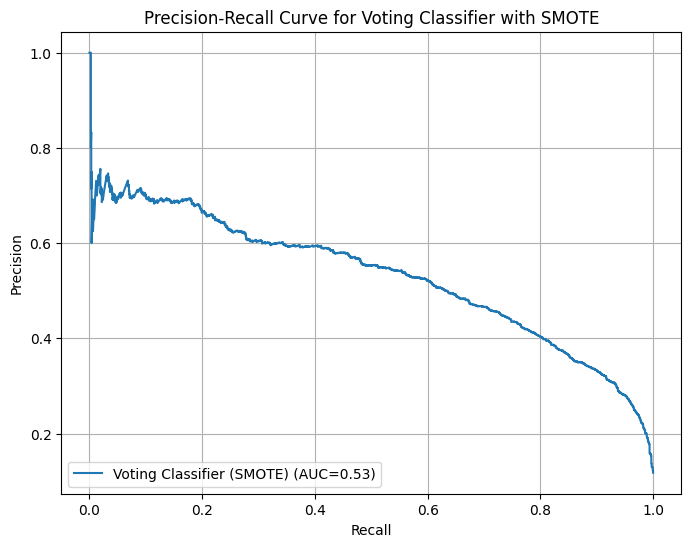

In [141]:
# Voting Classifier

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (class 1)
y_scores_voting_smote = voting_pipeline_smote.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_test, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={auc_score:.2f})')

# Plot Precision-Recall Curve for Voting Classifier with SMOTE
plt.figure(figsize=(8, 6))

plot_precision_recall_curve(y_test, y_scores_voting_smote, "Voting Classifier (SMOTE)")

# Add plot labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Voting Classifier with SMOTE')
plt.legend(loc='lower left')
plt.grid()
plt.show()



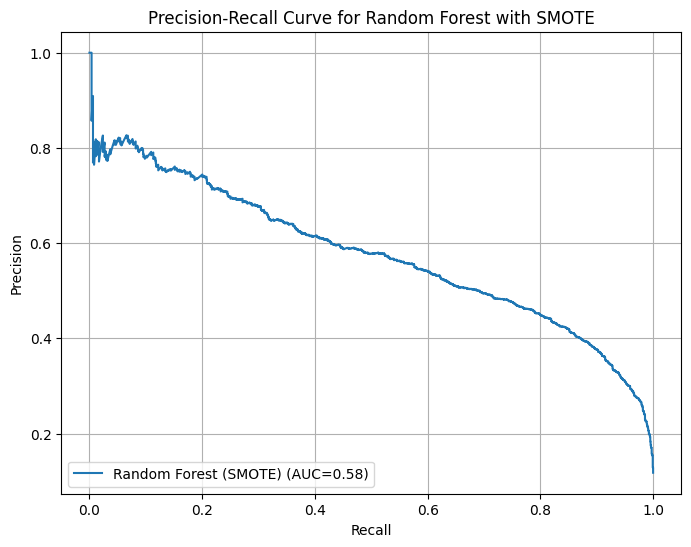

In [134]:
# Random Forest

from sklearn.metrics import precision_recall_curve, auc

# Get the predicted probabilities for the positive class (class 1)
y_scores_rf_smote = best_rf_smote.predict_proba(X_test)[:, 1] 

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_test, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={auc_score:.2f})')

# Plot Precision-Recall Curve for Random Forest with SMOTE
plt.figure(figsize=(8, 6))

plot_precision_recall_curve(y_test, y_scores_rf_smote, "Random Forest (SMOTE)")

# Add plot labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest with SMOTE')
plt.legend(loc='lower left')
plt.grid()
plt.show()


## AUC Comparison

The AUC (Area Under the Curve) scores provide insight into each model's ability to distinguish between potential subscribers and non-subscribers. Random Forest achieved the highest AUC score at 0.58, demonstrating its strong capacity to differentiate between classes. However, this came at a high computational cost. AdaBoost, with an AUC of 0.55, also performed well in classifying potential customers while being more computationally efficient, making it a balanced choice. 

Both Bagging and the Voting Classifier yielded lower AUC scores of 0.53, indicating weaker discrimination ability between the classes. Despite the lower AUC for AdaBoost compared to Random Forest, the slight performance difference is outweighed by AdaBoost's faster training time and more practical application for business use. 

Thus, while Random Forest has the edge in AUC, AdaBoost remains the most balanced model for this marketing task, considering both predictive power and computational efficiency.

## Part 4: Performance Comparison 

Model	                      Accuracy	Precision	Recall	  F1 Score

Tuned Random Forest with SMOTE	88.79	  51.97	     63.45	    57.14

Voting Classifier with SMOTE	84.69	  41.92	      77.6	    54.43

Tuned Bagging with SMOTE	     88.9	   52.6	      58.26     55.29

Tuned AdaBoost with SMOTE	      88.3	   50.27	  64.46	    56.48

Tuned k-NN	                     88.57	   52.38	   33.1	     40.57

Tuned Logistic Regression with Class Weighting	84.72	42.41	82.85	56.1


When comparing the performance of all models, it is important to consider both their accuracy and the balance between precision and recall, as well as the time required to run each model.

Logistic Regression: This baseline model had an accuracy of 84.72%, with high recall (82.85%) but lower precision (42.41%), leading to a moderate F1 score (56.10%). The model performed well in identifying potential subscribers (high recall), but with a high number of false positives, it’s less precise. Logistic Regression’s fast computation makes it useful for quick predictions but not ideal for minimizing false positives.

k-NN: This model achieved a strong accuracy (88.57%), but its recall (33.10%) was very low, indicating that it missed many actual positives. Its precision (52.38%) is reasonable, but with a low F1 score (40.57%), it underperformed compared to other models. k-NN is computationally expensive, and given its poor recall, it’s not well-suited for this task.

AdaBoost with SMOTE: With accuracy (88.30%), recall (64.46%), and a balanced F1 score (56.48%), AdaBoost provides a solid balance between identifying true positives and minimizing false positives. Its computational efficiency further solidifies it as a top choice for this business case, offering both performance and scalability.

Bagging with SMOTE: Bagging delivered the highest accuracy (88.90%) among the models, but with slightly lower recall (58.26%) than AdaBoost. The F1 score (55.28%) reflects that Bagging has good generalization ability, but its longer computation time makes it less practical for frequent retraining.

Voting Classifier with SMOTE: This model had a strong recall (77.60%) but lower precision (41.92%), resulting in a relatively high number of false positives and a lower accuracy (84.69%). While it excels in identifying potential subscribers, the high false positive rate reduces its overall utility.

Random Forest with SMOTE: Accuracy (88.79%) and balanced precision (51.97%) and recall (63.45%) make Random Forest a strong performer. However, it has the longest training time, making it inefficient for frequent model updates, despite its good F1 score (57.14%).

Conclusion:
While Random Forest and Bagging have slightly higher accuracy, AdaBoost offers a better trade-off between accuracy, recall, and computational cost, making it the most balanced and efficient model for business needs.

## Part 5: Interpretation and Justification

We will look in detail how each model performed this way.

AdaBoost adjusts the importance (weights) of misclassified instances in each iteration. Without SMOTE, the model focuses more on correcting misclassifications of the majority class, which results in higher precision but lower recall.
SMOTE oversamples the minority class, allowing the model to better learn the characteristics of subscribers. This leads to a substantial improvement in recall (from 37.61% to 64.46%) because the model is now more sensitive to identifying positive cases. However, AdaBoost updates weights based on misclassified instances, so by increasing the number of synthetic minority class examples, it can over-focus on correctly classifying these, potentially leading to more false positives, which lowers precision. This explains why precision dropped from 61.64% to 50.27%.
Therefore, AdaBoost focuses on correcting misclassified examples, resulting in strong recall while maintaining moderate computational efficiency. 

Without SMOTE or the base Bagging Classifier tends to focus on the majority class due to the way it samples the data. This leads to higher precision because the model is conservative in predicting positives, reducing the number of false positives. However, this comes at the cost of lower recall because the model misses many actual positive cases (subscribers), as they are underrepresented in the imbalanced dataset.
The Bagging classifier (SMOTE) increases the representation of the minority class, allowing the model to learn more about subscribers. This improves recall because the model becomes more sensitive to the minority class, catching more true positives (subscribers).But, since Bagging involves training multiple decision trees on different subsets of the data, SMOTE also introduces more synthetic samples, which can reduce the model’s precision. The synthetic samples can introduce noise, leading to more false positives and, therefore, lower precision.
Therefore, Bagging performed similarly to Random Forest, with slightly faster training times still high and as large datasets will be introduced, it would still demand significant computational resources. 

A voting classifier aggregates the predictions of multiple models (such as Logistic Regression, Random Forest, k-NN, etc.). When the underlying models are trained on imbalanced data without SMOTE, they tend to favor the majority class. The result is higher precision but lower recall.
When SMOTE is applied, the individual models in the ensemble are trained on a balanced dataset, leading to better recall at the expense of precision, as the models now predict more positives.
SMOTE helps the model to learn more from the minority class (subscribers) by oversampling them. This leads to a substantial improvement in recall because the model now predicts more positives (subscribers). The recall increase from 35.29% to 77.6% is a direct result of the model becoming more sensitive to the minority class.
Therefore, the Voting Classifier, despite high recall, suffered from low precision, leading to higher false positives and marketing bandwidth inefficiency.

The base Random Forest model was biased toward the majority class (non-subscribers), so it had high precision but low recall, meaning it predicted fewer subscribers correctly but was more accurate when it did.
However, the Random Forest model (with SMOTE) became more sensitive to the minority class (subscribers), which improved recall but introduced more false positives, leading to lower precision.
The results we're seeing from Random Forest are expected and not underwhelming. To conclude, Random Forest delivered high accuracy and balanced precision-recall, leveraging multiple decision trees to capture complex patterns. However, its computational cost was extremely high, which impacted its practicality for real-time business use. 

The ensemble models performed as expected due to their inherent ability to reduce variance and improve generalization. The results were in line with expectations: Random Forest performed well but at a significant cost, while AdaBoost provided a balanced approach between accuracy and computational efficiency.

For a business context, AdaBoost is the most suitable model. Its balance between precision, recall, and reasonable computational cost makes it ideal for marketing decisions where timely, scalable predictions are needed. The decision was based on optimizing both performance metrics and computational efficiency, considering the precision-recall trade-off and the need for cost-effective targeting in marketing campaigns. AdaBoost provides the best trade-off between capturing potential customers and minimizing unnecessary outreach.